In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import autograd.numpy as np
from autograd import grad
from autograd.core import primitive
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.cm as cm
from scipy.misc import imread, imresize, imsave
from PIL import Image
import scipy.io
from scipy.sparse import csr_matrix
import os
import caffe

In [3]:
# img = imread('data/train/05026.png', mode='RGB')
# lmap = imread('data/train/05026.ppm')
img = imread('data/test/10423.png', mode='RGB')
lmap = imread('data/test/10423.ppm')
in_ = np.array(img, dtype=np.float32)
in_ = in_[:, :, ::-1] - np.array([104.00698793,116.66876762,122.67891434])
in_ = in_.transpose([2, 0, 1])

In [8]:
# set up
caffe.set_mode_gpu()
caffe.set_device(0)
# load net
#net = caffe.Net('models/hed.deploy', 'models/hed+fp.caffemodel', caffe.TEST)
net = caffe.Net('models/hed.deploy', 'models/hough_2k.caffemodel', caffe.TEST)
# shape for input (data blob is N x C x H x W), set data
net.blobs['data'].reshape(1, *in_.shape)
net.blobs['data'].data[...] = in_
# run net and take argmax for prediction
net.forward()
# out1 = net.blobs['sigmoid-dsn1'].data[0][0,:,:]
# out2 = net.blobs['sigmoid-dsn2'].data[0][0,:,:]
# out3 = net.blobs['sigmoid-dsn3'].data[0][0,:,:]
# out4 = net.blobs['sigmoid-dsn4'].data[0][0,:,:]
# out5 = net.blobs['sigmoid-dsn5'].data[0][0,:,:]
fuse = net.blobs['sigmoid-fuse'].data[0][0,:,:]

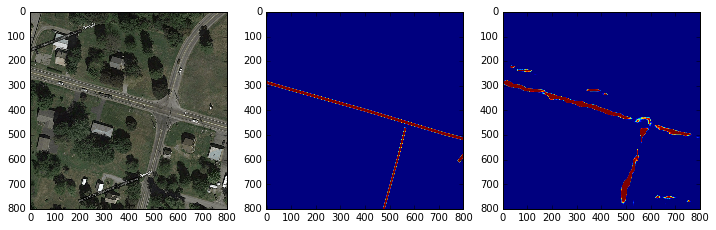

In [9]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(img)
plt.subplot(132)
plt.imshow(lmap)
plt.subplot(133)
plt.imshow(fuse)

In [6]:
#imsave('../prob.ppm', fuse)
#imsave('../tgt.ppm', lmap)
prob = fuse
tgt = lmap
H, W = 80, 80
prob_small = imresize(fuse, [W, H]).astype(float)/255.
tgt_small = imresize(lmap, [W, H]).astype(float)/255.
#imsave('../prob-small.ppm', prob_small)
#imsave('../tgt-small.ppm', tgt_small)

# Hough

In [7]:
THETA = 180
rho_min = int(np.floor(-np.sqrt(H*H+W*W)))
rho_max = int(np.ceil(np.sqrt(H*H+W*W)))
RHO = rho_max - rho_min
theta_step = 1
rho_step = 1

sin = lambda x: np.sin(x * np.pi / 180)
cos = lambda x: np.cos(x * np.pi / 180)
sin_ = [sin(x) for x in xrange(-90, 90)]
cos_ = [cos(x) for x in xrange(-90, 90)]

val_ = np.zeros(H*W*THETA, dtype=float)
ci_ = np.zeros(H*W*THETA, dtype=int)
ro_ = np.zeros(H*W+1, dtype=int)
for idx in xrange(H*W*THETA):
    hw = idx / THETA
    theta_i = idx % THETA
    h, w = hw/W, hw%W
    ro = hw * THETA
    
    rho = h * sin_[theta_i] + w * cos_[theta_i]
    rho_i = int( (rho-rho_min)/rho_step )
    ci = theta_i * RHO + rho_i
    val_[ro+theta_i] = 1.
    ci_[ro+theta_i] = ci
    
    if theta_i == 0:
        ro_[hw] = ro
        if idx == H*W*THETA-1:
            ro[hw+1] = ro + THETA

hb = csr_matrix((val_, ci_, ro_), shape=(H*W, THETA*RHO), dtype=float)

@primitive
def forward_hough(bottom):
    h, w = bottom.shape
    return hb.transpose().dot(bottom.reshape(-1)).reshape((THETA, RHO))

def backward_hough(top_diff):
    h, w = top_diff.shape
    return hb.dot(top_diff.reshape(-1)).reshape((H, W))

def make_grad_forward_hough(top, bottom):
    return lambda top_diff: backward_hough(top_diff)

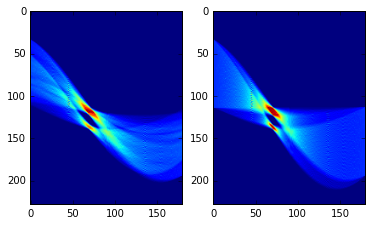

In [8]:
hft_prob_small = forward_hough(prob_small)
hft_tgt_small = forward_hough(tgt_small)
plt.subplot(121)
plt.imshow(hft_prob_small.T)
plt.subplot(122)
plt.imshow(hft_tgt_small.T)

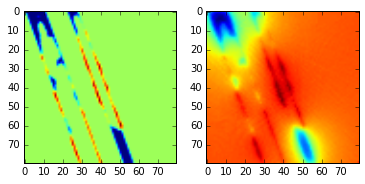

In [9]:
hft_diff_small = hft_prob_small - hft_tgt_small
prob_diff_small = backward_hough(hft_diff_small)
naive_diff_small = prob_small - tgt_small
plt.subplot(121)
plt.imshow(naive_diff_small)
plt.subplot(122)
plt.imshow(prob_diff_small)

In [10]:
hft_prob_small.min(), hft_prob_small.max()

(0.0, 80.92941176470589)

# Sigmoid

In [11]:
def forward_sigmoid(bottom):
    return 1 / (1 + np.exp(-bottom))

def forward_log(bottom):
    return np.log(1+bottom)

# Gaussian normalization

In [12]:
def forward_gn(bottom, std=1):
    h, w = bottom.shape
    m = np.mean(bottom)
    s = np.std(bottom)
    top = (bottom - m) / s * std
    return forward_sigmoid(top)

# ensure hft_tgt_small has been defined
def loss(hft_prob_small):
    gn_hft_prob = forward_gn(hft_prob_small)
    gn_hft_tgt = forward_gn(hft_tgt_small)
    return -np.sum(gn_hft_tgt*np.log(gn_hft_prob) +
                   (1-gn_hft_tgt)*np.log(1-gn_hft_prob))

backward_gn = grad(loss)

0.377437743328 0.999767604921
0.368148229485 0.999786698153


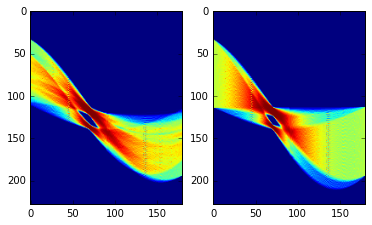

In [13]:
gn_prob = forward_gn(hft_prob_small)
gn_tgt = forward_gn(hft_tgt_small)
plt.subplot(121)
plt.imshow(gn_prob.T)
plt.subplot(122)
plt.imshow(gn_tgt.T)
print gn_prob.min(), gn_prob.max()
print gn_tgt.min(), gn_tgt.max()

25773.9892295
-4.40885949162 0.822852062404


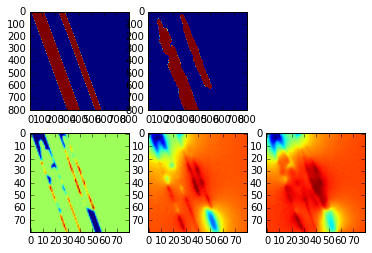

In [14]:
print loss(hft_prob_small)
hft_diff = backward_gn(hft_prob_small)
prob_diff = backward_hough(hft_diff)
plt.subplot(231)
plt.imshow(lmap)
plt.subplot(232)
plt.imshow(fuse)
plt.subplot(234)
plt.imshow(naive_diff_small)
plt.subplot(235)
plt.imshow(prob_diff_small)
plt.subplot(236)
plt.imshow(prob_diff)
print prob_diff.min(), prob_diff.max()

# Local response normalization

In [27]:
def forward_lrn(bottom, k=2, n=5, alpha=1e-4, beta=.75):
    h, w = bottom.shape
    top = np.zeros_like(bottom)
    for y in xrange(h):
        y_min = max(0, int(y-n/2))
        y_max = min(h-1, int(y+n/2))
        for x in xrange(w):
            x_min = max(0, int(x-n/2))
            x_max = min(w-1, int(x+n/2))
            roi = bottom[y_min:y_max, x_min:x_max]
            top[y, x] = bottom[y, x] / (k + alpha * np.sum(roi**2))**beta
    return top

0.0 6.77843278334
0.0 7.5092409543


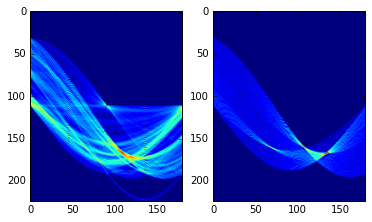

In [56]:
forward = lambda x: forward_lrn(x, k=10, n=5, alpha=.1, beta=.25)
lrn_prob = forward(hft_prob_small)
lrn_tgt = forward(hft_tgt_small)
plt.subplot(121)
plt.imshow(lrn_prob.T)
plt.subplot(122)
plt.imshow(lrn_tgt.T)
print lrn_prob.min(), lrn_prob.max()
print lrn_tgt.min(), lrn_tgt.max()

# Non max suppression

In [63]:
def forward_nms(bottom, n=3):
    h, w = bottom.shape
    top = np.zeros_like(bottom)
    for y in xrange(h):
        y_min = max(0, int(y-n/2))
        y_max = min(h-1, int(y+n/2))
        for x in xrange(w):
            x_min = max(0, int(x-n/2))
            x_max = min(w-1, int(x+n/2))
            roi = bottom[y_min:y_max, x_min:x_max]
            if (bottom[y, x] == np.max(roi)):
                top[y, x] = bottom[y, x]
    return top

0.0 36.4235294118
0.0 39.6235294118


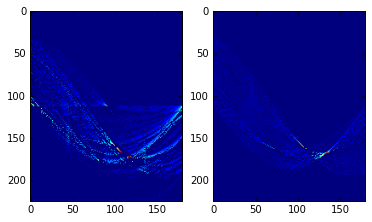

In [66]:
forward = lambda x: forward_nms(x, n=3)
nms_prob = forward(hft_prob_small)
nms_tgt = forward(hft_tgt_small)
plt.subplot(121)
plt.imshow(nms_prob.T)
plt.subplot(122)
plt.imshow(nms_tgt.T)
print nms_prob.min(), nms_prob.max()
print nms_tgt.min(), nms_tgt.max()